In [ ]:
# increase our dataset .. what can we do ?
# 1. Download from Internet (not possible for closed domain solutions)
# 2. Replicate images (WE SHOULD NOT REPLICATE IMAGES, as it WILL LEAD TO OVERFITTING)
# 3. Augmentation

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, os
from tqdm.auto import tqdm
import shutil

In [ ]:
! mkdir -p /root/.kaggle
! mv kaggle.json /root/.kaggle
import kaggle

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 99% 806M/812M [00:09<00:00, 110MB/s]
100% 812M/812M [00:09<00:00, 92.3MB/s]


In [ ]:
! unzip -q dogs-vs-cats.zip
! unzip -q train.zip

In [ ]:
! rm -rf sampleSubmission.csv test1.zip dogs-vs-cats.zip

In [ ]:
os.mkdir("images")
os.mkdir("images/cat")
os.mkdir("images/dog")

In [ ]:
source =   "train/"
dest_cat = "images/cat/"
dest_dog = "images/dog/"

for imageName in tqdm(os.listdir(source)):
  if imageName.startswith("cat"):
    shutil.copy(source + imageName, dest_cat)
  elif imageName.startswith("dog"):
    shutil.copy(source + imageName, dest_dog)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
os.mkdir("test")

In [ ]:
# Test Dataset -

test_dog = np.random.choice(os.listdir(dest_dog), 500, replace=False)
test_cat = np.random.choice(os.listdir(dest_cat), 500, replace=False)

for imageName in test_dog:
  shutil.move(dest_dog + imageName, "test")
for imageName in test_cat:
  shutil.move(dest_cat + imageName, "test")

In [ ]:
len(os.listdir("test"))

1000

In [ ]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                      horizontal_flip=True,
                                                      vertical_flip=True,
                                                      height_shift_range = 0.25,
                                                      width_shift_range=0.25,
                                                      rotation_range = 30,
                                                      validation_split=0.1)

In [ ]:
# Image Augmentation - does not increase the number of images
# It just makes sure the images are send with different augmentations across each epoch

In [ ]:
# You can read images using Keras's util also ...

In [ ]:
dog = "train/dog.0.jpg"
img = tf.keras.utils.load_img(dog) # PIL
img_arr1 = tf.keras.utils.img_to_array(img)
print(img_arr1.shape)
img_arr = img_arr1.reshape((1,) + img_arr1.shape)
print(img_arr.shape)

(375, 499, 3)
(1, 375, 499, 3)


In [ ]:
os.mkdir("aug")

In [ ]:
i = 0
for batch in idg.flow(img_arr, batch_size=1, save_to_dir="aug"):
  i+=1
  if i>9: # give us 9 different aug of this image
    break

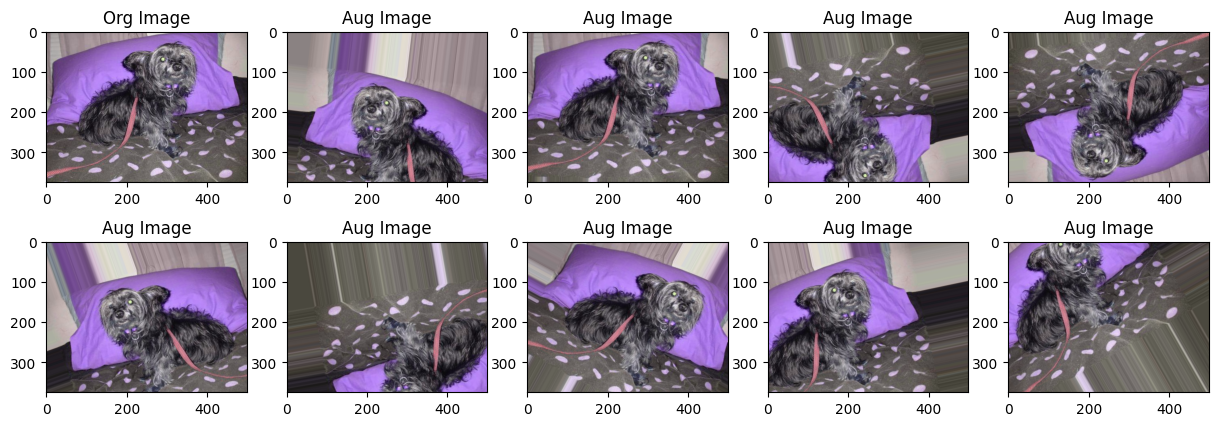

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(2, 5, 1)
plt.imshow(cv2.imread(dog))
plt.title("Org Image")

for index, i in enumerate(os.listdir("aug"), 1):
  if index > 9:
    break
  plt.subplot(2, 5, 1 + index)
  plt.imshow(cv2.imread("aug/" + i))
  plt.title("Aug Image")

In [ ]:
batch_size = 64

In [ ]:
train_idg = idg.flow_from_directory("images",
                                    target_size=(150, 150),
                                    batch_size=batch_size,
                                    subset="training")

Found 21600 images belonging to 2 classes.


In [ ]:
val_idg = idg.flow_from_directory("images",
                                  target_size = (150, 150),
                                  batch_size = batch_size,
                                  subset="validation")

Found 2400 images belonging to 2 classes.


In [ ]:
# Total Images      - 25K
# Test Images       - 1K
# Train Images      - 24k
# IDG Val_split     - 0.1
# Training Images   - 24k * 90% = 21600
# Validation Images - 24k * 10% = 2400

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((150, 150, 3), name="Input"))
model.add(tf.keras.layers.Flatten(name="Flat"))
model.add(tf.keras.layers.Dense(128, activation="relu", name="HL1"))
model.add(tf.keras.layers.Dense(16, activation="relu", name="HL2"))
model.add(tf.keras.layers.Dense(2, activation="softmax", name="Output"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flat (Flatten)              (None, 67500)             0         
                                                                 
 HL1 (Dense)                 (None, 128)               8640128   
                                                                 
 HL2 (Dense)                 (None, 16)                2064      
                                                                 
 Output (Dense)              (None, 2)                 34        
                                                                 
Total params: 8642226 (32.97 MB)
Trainable params: 8642226 (32.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["acc"])

In [ ]:
model.fit(train_idg, batch_size=batch_size, epoch=10, validation_data=val_idg)